**Kaggle team name**:🐧3-TreeHuggers-Rice,Rivas,Samman
1. Format: `🐧[BB Team#]-[Your fancy Kaggle group name]-[Students' names]`. 
  1. Eg. `🐧A-Heros-Fleischer,Melnikov`, where 🐧 identifies JHU and `A` identifies the Canvas group code

Your private LB score must be reproducible with this Colab. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation). Don't exceed runtime quota.

<small><hr style="margin:0;background-color:silver"><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small>

<hr color=darkblue>

# **🏆👂Phonemes**

<details><summary><font color=darkblue>More info and Kaggle API instructions</font></summary>

[Kaggle competition URL](https://www.kaggle.com/c/2722phonemes/rules). See competition rules, submission, grading, dataset, and performance metric. The **starter code** below produces a baseline model, which you should beat, while respecting the competition rules. Your code starts after the timer. This is your baseline model. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation) for reproducibility!

**Instructions for enabling Kaggle API in Colab**:
1. Accept competition rules before running [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials). [Loading Kaggle dataset example](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab)
1. In your Kaggle Account, [Create API Token](https://github.com/Kaggle/kaggle-api#api-credentials) and save the resulting **kaggle.json** file to the [root of your Google Drive](https://drive.google.com/drive/u/0/my-drive) 
2. In Colab, open **Files** panel 🗀 (on the left) and click gray folder icon <font color=gray>🖿</font> to mount your Google drive

Your Kaggle/Google Drive credentials are secure; and Colab's kaggle.json only lasts a Colab session.

</details>


In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 2722phonemes             # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 2722phonemes
Using competition: 2722phonemes
 teamId  teamName                                                              submissionDate       score    
-------  --------------------------------------------------------------------  -------------------  -------  
8157293  JA-Soundclout-Barrett-Rumman                                          2022-02-20 18:12:42  0.93840  
8152495  JC-Phonemes-Lee,Givre                                                 2022-02-20 18:57:04  0.93140  
8178607  IB-Pears-Ivanushkina, Miniakhmetov, Odnakov                           2022-02-20 17:07:43  0.93060  
8815539  arice24                                                               2022-06-26 09:21:01  0.93060  
8192016  DL-Mignogns-Emil Akopyan, Mikhail Vinogradov, Artur Babayan           2022-02-21 08:39:35  0.93020  
8191413  DD - cool_name - Ivanov,Ruban,Nikitin                                 2022-02-20 20:33:24 

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)

CPU times: user 174 ms, sys: 14 ms, total: 188 ms
Wall time: 194 ms


In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None) 

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O

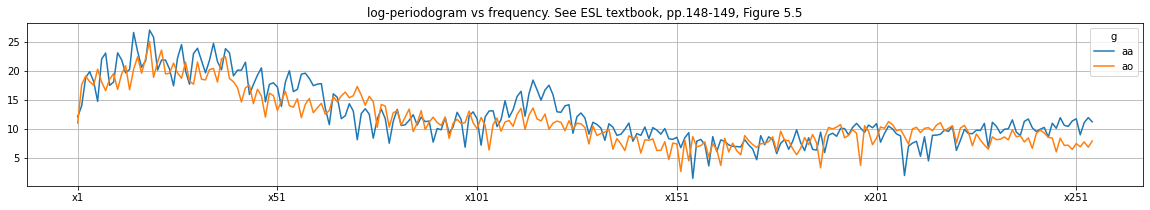

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

Below is a baseline model that produces the result on Kaggle leaderboard (LB).

In [ ]:
vX

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x248,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,9.31,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.90,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,9.88,13.78,15.60,15.90,10.43,13.74,13.27,11.67,16.85,16.37,...,6.11,7.22,6.61,7.62,7.48,5.26,5.54,6.20,7.80,99
9999,10.85,17.05,19.40,16.35,16.36,17.97,15.16,18.75,19.78,17.88,...,4.37,6.28,5.30,6.09,6.31,4.99,7.31,8.13,9.16,99


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Factor 4: 0.9798 Training/0.9753 OOB/0.943 Validation
# Factor 8: 0.9809 Training/0.9766 OOB/0.9375 Validation
downsample_factor = 4

tX_down = tX.groupby(np.floor(np.arange(len(tX.columns))//downsample_factor), axis=1).mean()
# poly = PolynomialFeatures(2)
# tX_down = poly.fit_transform(tX_down.select_dtypes(include=np.number))
# tX_down = pd.DataFrame(tX_down)
tX_down

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0
10000,16.20,19.52,20.17,22.48,23.82,21.05,21.05,21.61,21.98,21.58,...,8.35,9.90,9.40,10.24,10.51,9.57,10.90,10.62,11.19,100.0
10001,16.59,18.94,19.67,22.10,23.46,20.68,21.07,20.39,20.90,22.55,...,8.29,9.92,9.27,10.05,10.50,9.64,10.59,11.16,11.08,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,17.20,20.18,19.44,20.64,23.54,22.85,19.82,19.26,21.79,19.48,...,9.32,9.91,10.02,6.18,8.22,7.86,7.12,8.14,7.17,436.0
59999,15.02,15.28,15.19,16.68,15.42,14.02,14.93,16.02,14.61,13.19,...,15.34,16.09,13.02,14.59,15.14,15.20,15.33,12.98,12.92,436.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

n = 2000   # validation subsample
# vX0, vY0 = tX.iloc[:n,:], tY[:n]   # subsample for model selection experiments
# tX0, tY0 = tX.iloc[n:,:], tY[n:] # subsample for model training
vX0, vY0 = tX_down.iloc[:n,:], tY[:n]   # subsample for model selection experiments
tX0, tY0 = tX_down.iloc[n:,:], tY[n:] # subsample for model training

params = {}

# m = GradientBoostingClassifier(random_state=0, n_estimators=50, subsample=0.5) # 0.888
# m = RandomForestClassifier(random_state=0, oob_score=True, n_jobs=-1, max_samples=4000, max_depth=16, max_leaf_nodes=176, max_features=48) # 0.9435 Validation Score/0.92380 LB
# params = {"max_samples": (3000, 3500, 4000, 4500)} # 4000: 0.98418 training/0.9763 OOB
# params = {"max_depth":(12, 16, 20)} # 16: 0.98134 training/0.97382 OOB
# params = {"max_leaf_nodes": (144, 160, 176)} # 176: 0.97218 training/0.96486 OOB
# params = {"max_features": (32, 50, 48, 56, 64)} # 48: 0.97968 training/0.9727 OOB

# m = RandomForestClassifier(random_state=0, oob_score=True, n_jobs=-1)
# params = {"max_samples": (3000, 3500, 4000, 4500), "max_depth":(12, 16, 20), "max_leaf_nodes": (144, 160, 176), "max_features": (32, 50, 48, 56, 64)}

# 100 estimators: 0.9732/0.9670/0.944
# 75 estimators: 0.9769/0.9706/0.935 (downsampled by 2)
# 75 estimators: 0.9775/0.9726/0.933 (downsampled by 4)
m = RandomForestClassifier(random_state=0, oob_score=True, n_jobs=-1, n_estimators=75, max_samples=3500, max_depth=12, max_leaf_nodes=176, max_features=40) # 0.944 Validation Score

# params = {"min_samples_split": (4, 8, 12, 16, 20)}
# "min_impurity_decrease"
# "min_weight_fraction_leaf"
# "min_samples_split"

clr = GridSearchCV(estimator=m, param_grid=params, n_jobs=-1)

clr.fit(tX0, tY0)   # fit the model and show test error
print(clr.score(tX0, tY0))
print(clr.best_estimator_.oob_score_)

clr.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


GridSearchCV(estimator=RandomForestClassifier(max_depth=12, max_features=40,
                                              max_leaf_nodes=176,
                                              max_samples=3500, n_estimators=75,
                                              n_jobs=-1, oob_score=True,
                                              random_state=0),
             n_jobs=-1, param_grid={})

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


0.9775625
0.9726875


RandomForestClassifier(max_depth=12, max_features=40, max_leaf_nodes=176,
                       max_samples=3500, n_estimators=75, n_jobs=-1,
                       oob_score=True, random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix

print(clr.score(vX0, vY0))
confusion_matrix(vY0, clr.predict(vX0))

0.9335


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


array([[256,  46,   1,   0,   0],
       [ 46, 399,   0,   0,   0],
       [  0,   0, 328,   0,   0],
       [  0,  11,  19, 481,   5],
       [  0,   0,   0,   5, 403]])

In [ ]:
vX_down = vX.groupby(np.floor(np.arange(len(vX.columns))/downsample_factor), axis=1).mean()
# vX_down = poly.transform(vX_down.select_dtypes(include=np.number))
vX_down = pd.DataFrame(vX_down)
vX_down

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0
0,16.05,18.00,17.96,21.18,22.73,22.64,21.38,21.25,16.37,15.65,...,8.30,7.97,8.67,8.14,8.10,9.50,9.88,9.37,9.34,0.0
1,15.91,18.13,20.18,17.39,16.50,16.10,15.03,14.33,14.45,14.30,...,11.55,10.57,11.21,11.62,12.46,12.40,10.46,12.25,11.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9998,13.79,12.28,14.93,12.34,12.51,11.38,7.85,6.62,5.50,7.29,...,5.82,6.34,5.91,3.97,5.72,5.84,6.08,7.23,6.20,99.0
9999,15.91,17.06,18.73,19.57,22.43,20.98,18.98,17.55,20.66,15.64,...,5.84,7.50,6.40,5.97,5.82,6.39,6.16,6.00,7.40,99.0


In [ ]:
pY = pd.DataFrame(clr.predict(vX_down), index=range(1,len(vX_down)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
pd.DataFrame(df.g.fillna('unknown').value_counts(sort=False)).rename(columns={'g':'observed output g'}).T   # distribution of all train labels
pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
ToCSV(pY, 'MySubmission')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


,unknown,aa,ao,dcl,sh,iy
observed output g,10000,7635,11197,8340,9674,13154


g,aa,ao,dcl,iy,sh
predicted output g,1324,2460,1647,2617,1952


In [ ]:
pd.DataFrame(pY.value_counts()).rename(columns={'g':'predicted output g'})

,0
g,
iy,2617
ao,2460
...,...
dcl,1647
aa,1324


# **References:**

1. Remember to cite your sources!


<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 59 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and incorporating speaker ID
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and 
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 
 
